Detection of growing cores in GOES-16 ABI observations using a semi-Lagrangian framework

In [1]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from utils import io, abi, glm
from utils.plotting import goes_figure
from utils.flow import Flow
from utils import legacy_flow as lf

# Filter some warnings because pyart doesn't work nicely with notebooks

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

IO

In [2]:
# Load files
goes_data_path = './data/GOES16'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))

# Test with some multichannel data
ds_slice = {'x':slice(1325,1475), 'y':slice(725,850)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)
# Get dates
abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))


48


In [3]:
# Extract fields and load into memory
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
if hasattr(wvd, "compute"):
    wvd = wvd.compute()
bt = goes_ds.CMI_C13
if hasattr(bt, "compute"):
    bt = bt.compute()

Create Flow object

In [4]:
flow_kwargs = {'pyr_scale':0.5, 'levels':5, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':256}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

Find growth regions

In [24]:
# Get growth_rate of the wvd field and find markers
from utils.detection import detect_growth_markers
wvd_growth, growth_markers = detect_growth_markers(flow, wvd)

/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


In [34]:
print('Growth above threshold: area =', np.sum(wvd_growth.data>=0.5))
print('Detected markers: area =', np.sum(growth_markers.data!=0))
print('Detected markers: n =', growth_markers.data.max())


Growth above threshold: area = 2855
Detected markers: area = 2956
Detected markers: n = 18


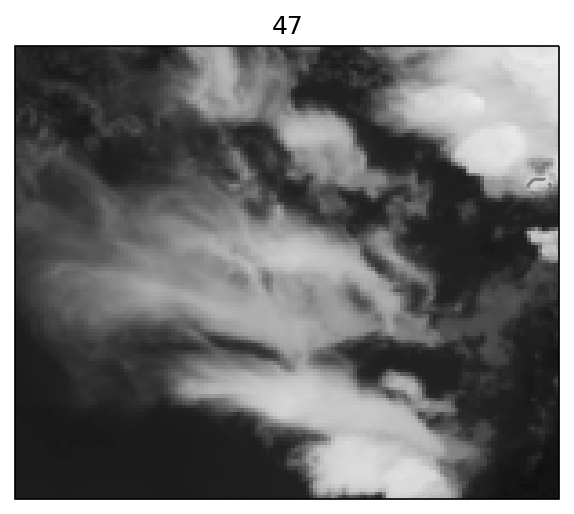

In [77]:
fig = goes_figure(goes_ds, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
bt_img = ax1.imshow(bt[0], vmin=190, vmax=310, cmap='binary')
# growth_cntr = [ax1.contourf(wvd_diff_filtered[0], np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu', alpha=0.5)]
label_cntrs = []
for j in np.unique(growth_markers.data[growth_markers!=0]):
    if j >= 10:
        ls = ['--']
    else:
        ls=['-']
    label_cntrs.append(ax1.contour(growth_markers[0]==j, [0.5], colors=['C0%1d'%(j%10)], linestyles=ls))
t = plt.title('0')

def init():
    return bt_img, label_cntrs, t

def animate(i):
    bt_img.set_data(bt[i])
    
#     for coll in growth_cntr[0].collections:
#         coll.remove()
#     growth_cntr[0] = ax1.contourf(wvd_diff_filtered[i], np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu', alpha=0.5)
    
    for cntr in label_cntrs:
#         label_cntrs.remove(cntr)
        for coll in cntr.collections:
            try:
                coll.remove()
            except:
                pass
    
    for j in np.unique(growth_markers.data[growth_markers!=0]):
        if j >= 10:
            ls = ['--']
        else:
            ls=['-']
        label_cntrs.append(ax1.contour(growth_markers[i]==j, [0.5], colors=['C0%1d'%(j%10)], linestyles=ls))
    
    t.set_text(str(i))
    
    return bt_img, label_cntrs, t

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=48, 
                               interval=50, blit=False)
from IPython.display import HTML, Image, display
HTML(anim.to_jshtml())

In [7]:
# Get GLM data
# Process new GLM data
glm_files = sorted(sum([sorted(io.find_glm_files(date, satellite=16,
                                     save_dir=goes_data_path,
                                     replicate_path=True, check_download=True,
                                     n_attempts=1, download_missing=True))
                 for date in dates], []))
glm_files = {io.get_goes_date(i):i for i in glm_files}
glm_grid = glm.regrid_glm(glm_files, goes_ds, corrected=False)

In [29]:
from utils.validation import get_min_dist_for_objects, get_marker_distance

In [30]:
marker_distance = get_marker_distance(growth_markers)
glm_distance = get_marker_distance(glm_grid)

markers:
n = <xarray.DataArray ()>
array(18)
Coordinates:
    y_image  float32 0.08624
    x_image  float32 -0.03136
0.6043541364296081
1.0
total GLM flashes:  3601.0


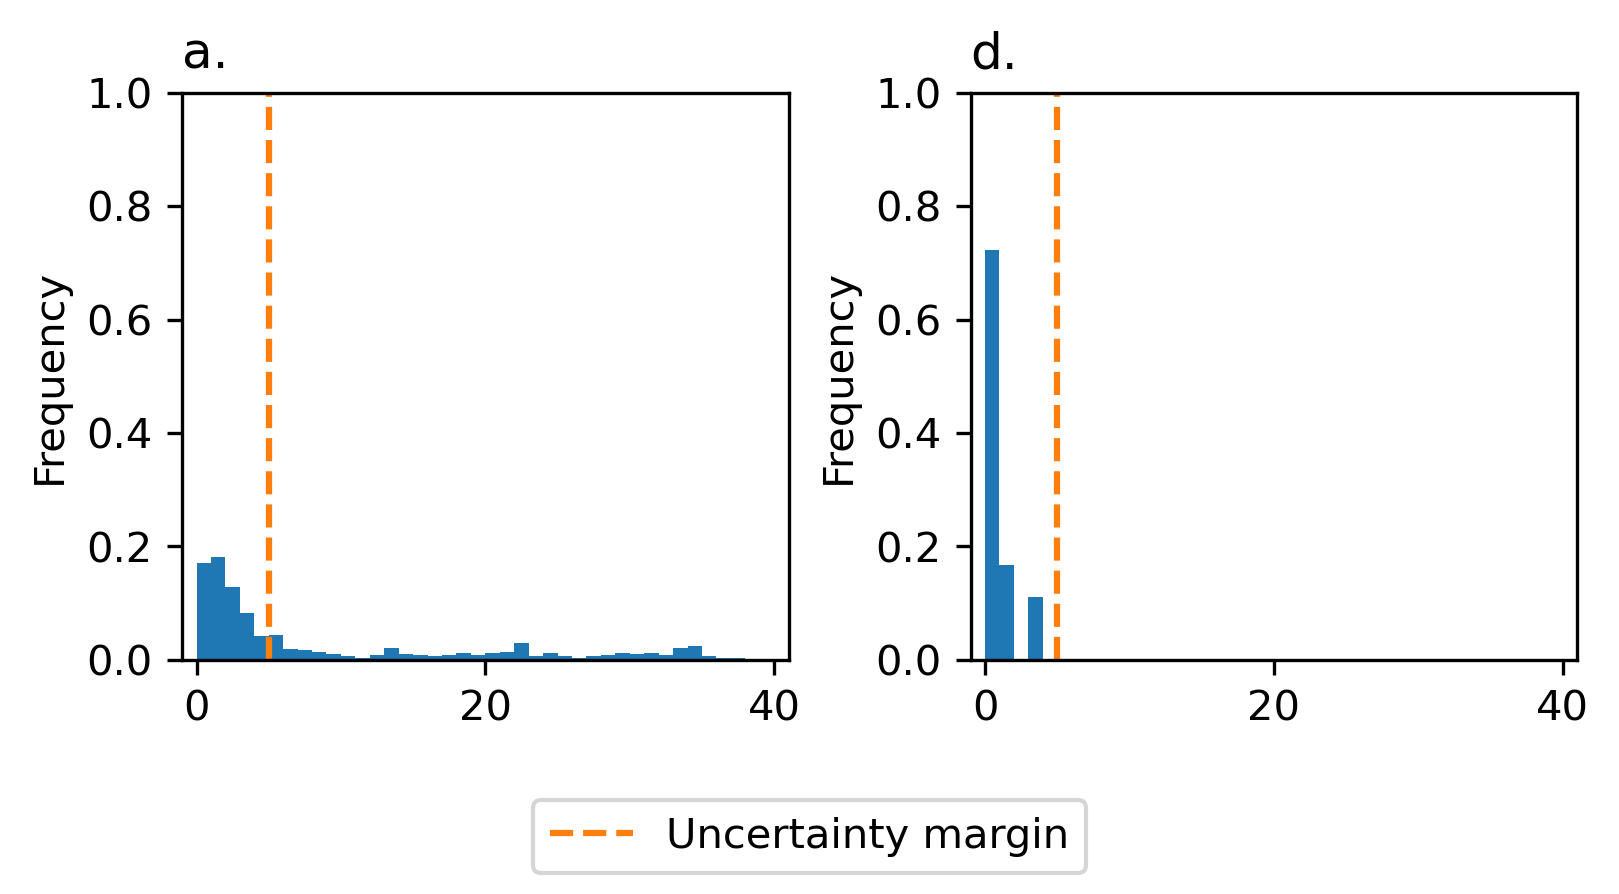

In [31]:
fig = plt.figure(dpi=300, figsize=(6,3))

plt.subplot(121)
h1 = plt.hist(marker_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(122)
h2 = plt.hist(get_min_dist_for_objects(glm_distance, growth_markers)[0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(wspace=0.3, bottom=0.25)

print('markers:')
print('n =', growth_markers.max())
print(np.sum(h1[0][:5]))
print(np.sum(h2[0][:5]))

print('total GLM flashes: ', np.sum(glm_grid.data))


In [35]:
from utils.analysis import apply_func_to_labels, apply_weighted_func_to_labels, flat_label, get_step_labels_for_label

In [36]:
tt,yy,xx = np.meshgrid(goes_ds.t, goes_ds.y, goes_ds.x, indexing='ij')

In [40]:
x_markers = apply_weighted_func_to_labels(flat_label(growth_markers.data!=0), 
                              xx, wvd_growth.data, lambda x, w: np.average(x, weights=w))
y_markers = apply_weighted_func_to_labels(flat_label(growth_markers.data!=0), 
                              yy, wvd_growth.data, lambda x, w: np.average(x, weights=w))

In [179]:
# x_markers = apply_func_to_labels(flat_label(filtered_marker_labels!=0), xx, np.nanmean)
# y_markers = apply_func_to_labels(flat_label(filtered_marker_labels!=0), yy, np.nanmean)

In [43]:
get_step_labels_for_label(growth_markers.data)[0]

array([ 1,  4,  7, 10, 13, 17], dtype=int32)

In [49]:
t_steps = [apply_func_to_labels(flat_label(growth_markers.data!=0), bt.data, lambda x: np.nanmean(x))[get_step_labels_for_label(growth_markers.data)[i]-1]
           for i in range(growth_markers.data.max())]

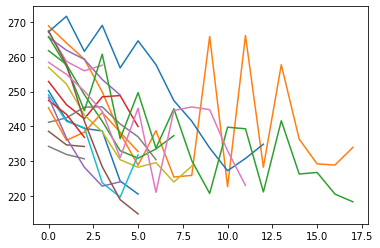

In [52]:
for i in range(len(t_steps)):
    plt.plot(t_steps[i])

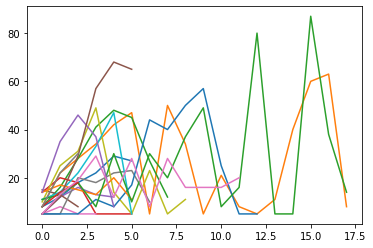

In [58]:
for i in range(growth_markers.data.max()):
    plt.plot(apply_func_to_labels(flat_label(growth_markers.data!=0), np.ones(wvd.shape), lambda x: np.sum(x))[get_step_labels_for_label(growth_markers.data)[i]-1])

In [59]:
flat_marker_labels = flat_label(growth_markers.data!=0)

In [60]:
flat_marker_labels.max()

138

In [72]:
np.unique(flat_marker_labels[growth_markers.data==2])

array([ 2,  5,  8, 11, 14, 18, 19, 22, 25, 26, 30, 31, 34, 35, 38, 42, 46,
       49], dtype=int32)

In [73]:
get_step_labels_for_label(growth_markers.data)[1]

array([ 2,  5,  8, 11, 14, 18, 19, 22, 25, 26, 30, 31, 34, 35, 38, 42, 46,
       49], dtype=int32)

In [74]:
i=1; apply_func_to_labels(flat_label(growth_markers.data!=0), np.ones(wvd.shape), lambda x: np.sum(x))[get_step_labels_for_label(growth_markers.data)[i]-1]

array([ 8., 22., 28., 34., 42., 47.,  5., 50., 34.,  5., 21.,  8.,  5.,
       11., 40., 60., 63.,  8.])

In [81]:
ndi.find_objects(growth_markers)

[(slice(0, 6, None), slice(47, 54, None), slice(103, 113, None)),
 (slice(0, 14, None), slice(75, 91, None), slice(119, 138, None)),
 (slice(0, 8, None), slice(86, 94, None), slice(118, 130, None)),
 (slice(5, 11, None), slice(48, 56, None), slice(111, 119, None)),
 (slice(8, 13, None), slice(22, 27, None), slice(83, 89, None)),
 (slice(11, 14, None), slice(54, 60, None), slice(106, 112, None)),
 (slice(11, 15, None), slice(61, 66, None), slice(122, 126, None)),
 (slice(14, 21, None), slice(24, 30, None), slice(85, 92, None)),
 (slice(14, 20, None), slice(52, 66, None), slice(112, 127, None)),
 (slice(14, 20, None), slice(70, 78, None), slice(120, 131, None)),
 (slice(15, 23, None), slice(32, 43, None), slice(99, 115, None)),
 (slice(20, 26, None), slice(25, 32, None), slice(89, 95, None)),
 (slice(21, 32, None), slice(100, 111, None), slice(105, 128, None)),
 (slice(23, 26, None), slice(98, 104, None), slice(123, 129, None)),
 (slice(24, 29, None), slice(68, 77, None), slice(126, 135,

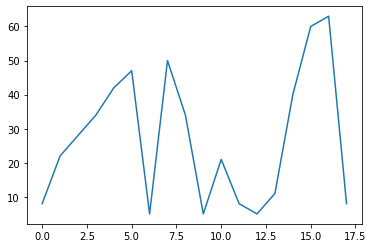

In [78]:
i=1
plt.plot(apply_func_to_labels(flat_label(growth_markers.data!=0), np.ones(wvd.shape), lambda x: np.sum(x))[get_step_labels_for_label(growth_markers.data)[i]-1])

In [79]:
len(apply_func_to_labels(flat_label(growth_markers.data!=0), np.ones(wvd.shape), lambda x: np.sum(x))[get_step_labels_for_label(growth_markers.data)[i]-1])

18

In [80]:
get_step_labels_for_label(growth_markers.data)[1].size

18